# Kernel Density Estimation (KDE, MACS 30200)
### by [Richard W. Evans](https://sites.google.com/site/rickecon/), April 2018
The code in this Jupyter notebook was written using Python 3.6.

A kernel density estimator (KDE) is a nonparametric estimator that can be used as an unsupervised learning model for any function. But it is especially effective at estimating distributions. KDE's also have the property of smoothing data. It is in this sense that KDE's have some similar properties to the spline functions we studied last term.

In the maximum likelihood estimation (MLE) and generalized method of moments (GMM) notebooks from last term, we estimated the parameters of flexible parametric distributions to fit the data. With KDE, we are doing the same thing with nonparametric distributions.

## 1. KDE intuition from histogram
See VanderPlas KDE notebook.

## 2. KDE mathematical specification
See Hastie, et al (2009, Section 6.6). A type of "averaged shifted histogram" estimator as described in Scott (2015, p. 138) is the following,

$$ \hat{f}_{X}(x_0) = \frac{{\#}x_i\in\mathcal{N}(x_0)}{N\lambda} $$

where $\mathcal{N}(x_0)$ is a small metric neighborhood around $x_0$ of width $\lambda$. Another way to write this is:

$$ \hat{f}_{X}(x_0) = \frac{\sum_{i}\mathcal{I}\Bigl(\text{abs}(x_i - x_0) > \frac{\lambda}{2}\Bigr)}{N\lambda} $$

You can think of the function in the numerator as a uniform distribution of length $\lambda$ and height of 1 centered around $x_0$.

A more general function in the numerator is called a kernel. Different kernels can provide different shapes, properties, and smoothness,

$$ \hat{f}_{X}(x_0) = \frac{1}{N\lambda}\sum_{i}K_\lambda(x_0,x_i) $$

where $K_\lambda(x_0,x_i)$ is the kernel function.

Six prominent kernel functions are used in Sci-kit Learn's [kernel density estimation function](http://scikit-learn.org/stable/modules/density.html): tophat (uniform), Gaussian, Epanechnikov, exponential, linear (hat), and cosine. 

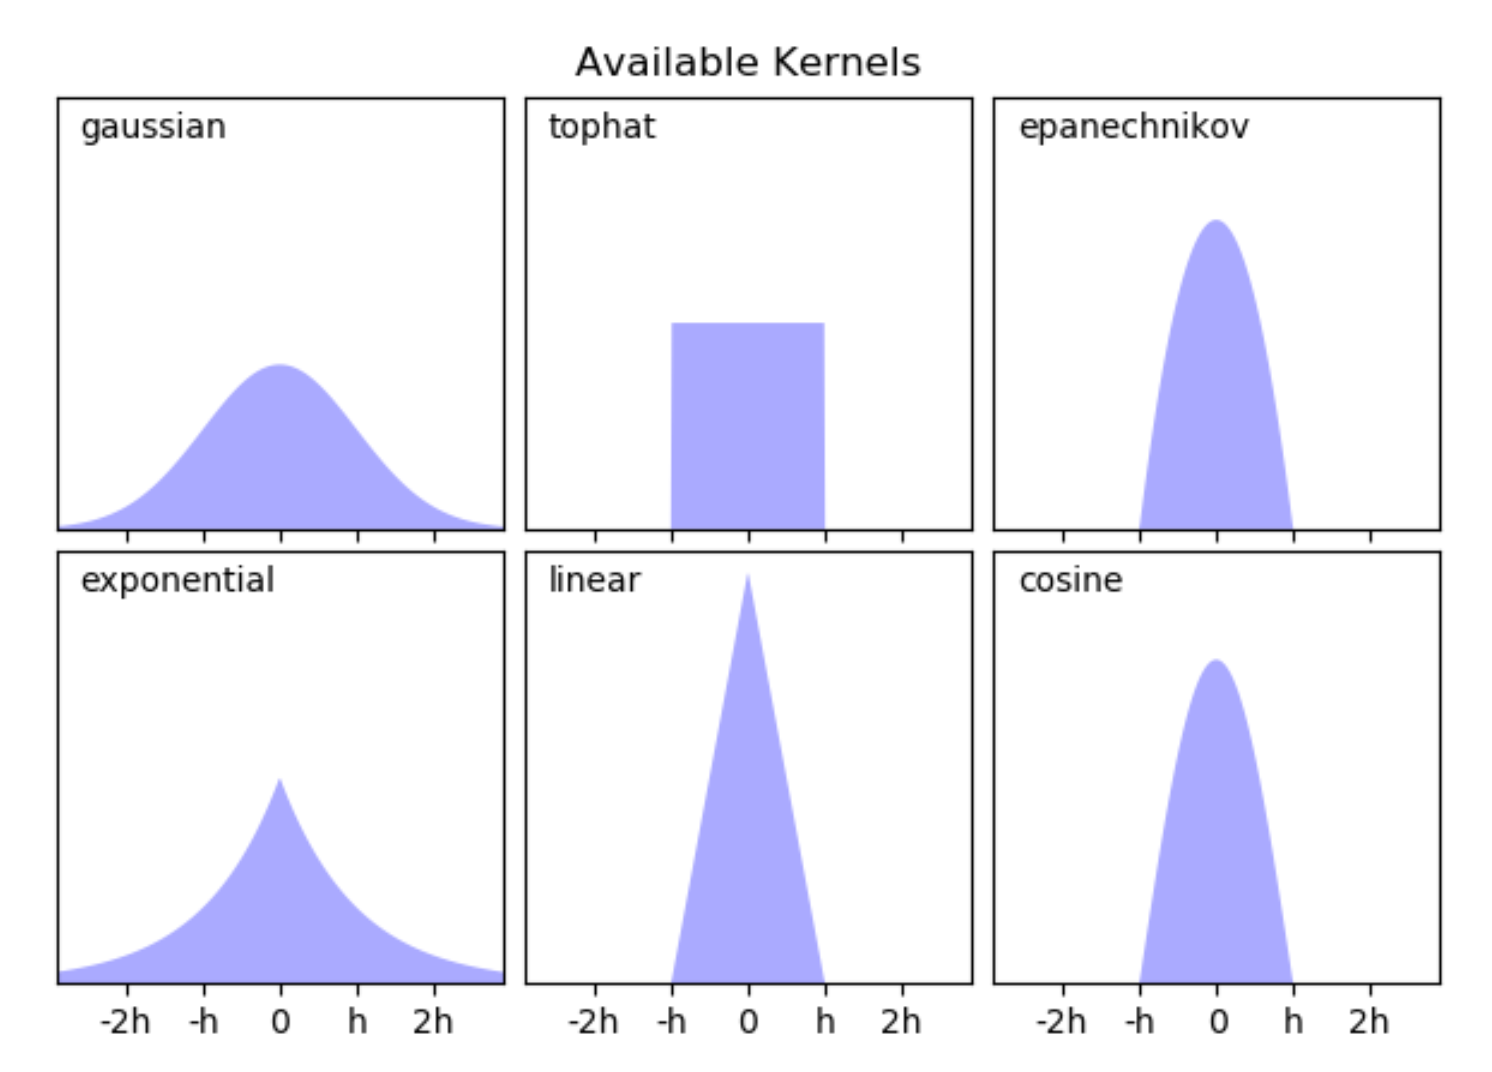

## 3. Examples


### 3.1. Two-dimensional data: Old Faithful geyser duration
The following `geyser.csv` dataset includes 107 measurements of the duration of an eruption of the Old Faithful geyser in Yellowstone National Park.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

geyser_dur = pd.read_csv('data/geyser.csv', names =['duration'])
geyser_dur

,duration
0,4.37
1,3.87
2,4.00
3,4.03
4,3.50
5,4.08
6,2.25
7,4.70
8,1.73
9,4.93


If we describe the `geyer_dur` duration variable, we see that the average duration is 3.45 minutes.

In [2]:
geyser_dur.describe()

,duration
count,107.000000
mean,3.459907
std,1.040295
min,1.670000
25%,2.300000
50%,3.800000
75%,4.250000
max,4.930000


A univariate histogram of these data looks pretty uniform between 1.67 and 4.93 minutes.

In [3]:
num_bins = 30
weights = (1 / geyser_dur.shape[0]) * np.ones_like(geyser_dur)
n, bin_cuts, patches = plt.hist(geyser_dur, num_bins, weights=weights, edgecolor='k')
plt.xticks(np.round_(bin_cuts, 1))
plt.title('Histogram of geyser duration (mins)', fontsize=17)
plt.xlabel(r'Duration (mins)')
plt.ylabel(r'Percent of observations in bin')

<IPython.core.display.Javascript object>

ValueError: weights should have the same shape as x

Now let's look at how things change when we look at the persistence of eruption duration length by looking at a 2-D histogram of eruption durations in period-t and eruption duration in periot-(t+1).

In [4]:
# break down data into two variables - 
# one vector thats all of the duration
# one vector thats second element all the way to the last element
# then compare those
# duration at time t and duration at time t + 1
# look at the persistence of duration in eruptions

dur_t = geyser_dur['duration'][:-1]
dur_t = pd.Series(dur_t, name='dur_t')
dur_tp1 = geyser_dur['duration'].shift(-1).dropna()
dur_tp1 = pd.Series(dur_tp1, name='dur_tp1')
dur_tp1

0      3.87
1      4.00
2      4.03
3      3.50
4      4.08
5      2.25
6      4.70
7      1.73
8      4.93
9      1.73
10     4.62
11     3.43
12     4.25
13     1.68
14     3.92
15     3.68
16     3.10
17     4.03
18     1.77
19     4.08
20     1.75
21     3.20
22     1.85
23     4.62
24     1.97
25     4.50
26     3.92
27     4.35
28     2.33
29     3.83
       ... 
76     4.42
77     1.90
78     4.63
79     2.93
80     3.50
81     1.97
82     4.28
83     1.83
84     4.13
85     1.83
86     4.65
87     4.20
88     3.93
89     4.33
90     1.83
91     4.53
92     2.03
93     4.18
94     4.43
95     4.07
96     4.13
97     3.95
98     4.10
99     2.72
100    4.58
101    1.90
102    4.50
103    1.95
104    4.83
105    4.12
Name: dur_tp1, dtype: float64

To make a 2D histogram using matplotlib, you have to use the NumPy function `histogram2d()` and then port the objects into a 3D bar chart using matplotlib's `bar3D()` function.

<IPython.core.display.Javascript object>


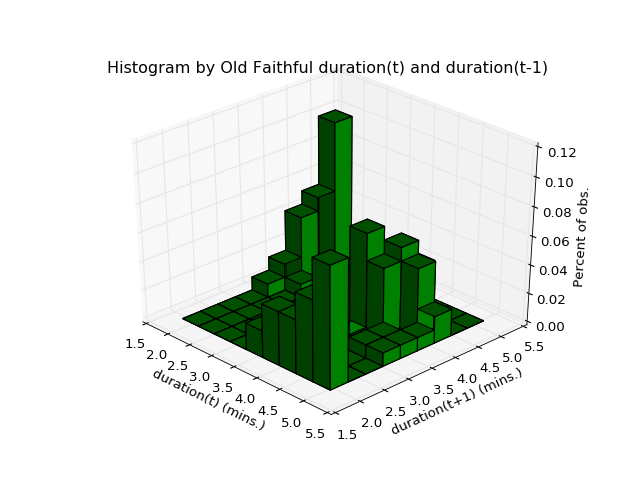

In [5]:
'''
--------------------------------------------------------------------
bin_num  = integer > 2, number of bins along each axis
hist     = (bin_num, bin_num) matrix, bin percentages
xedges   = (bin_num+1,) vector, bin edge values in x-dimension
yedges   = (bin_num+1,) vector, bin edge values in y-dimension
x_midp   = (bin_num,) vector, midpoints of bins in x-dimension
y_midp   = (bin_num,) vector, midpoints of bins in y-dimension
elements = integer, total number of 3D histogram bins
xpos     = (bin_num * bin_num) vector, x-coordinates of each bin
ypos     = (bin_num * bin_num) vector, y-coordinates of each bin
zpos     = (bin_num * bin_num) vector, zeros or z-coordinates of
            origin of each bin
dx       = (bin_num,) vector, x-width of each bin
dy       = (bin_num,) vector, y-width of each bin
dz       = (bin_num * bin_num) vector, height of each bin
--------------------------------------------------------------------
'''
fig = plt.figure()
ax = fig.add_subplot(111, projection ='3d')
bin_num = int(9)
hist, xedges, yedges = np.histogram2d(dur_t, dur_tp1, bins=bin_num)
hist = hist / hist.sum() # Normalize so that the percentages sum to 1

x_midp = xedges[:-1] + 0.5 * (xedges[1] - xedges[0])
y_midp = yedges[:-1] + 0.5 * (yedges[1] - yedges[0])
elements = (len(xedges) - 1) * (len(yedges) - 1)
ypos, xpos = np.meshgrid(y_midp, x_midp)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(elements)
dx = (xedges[1] - xedges[0]) * np.ones_like(bin_num)
dy = (yedges[1] - yedges[0]) * np.ones_like(bin_num)
dz = hist.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='g', zsort='average', edgecolor='k')
ax.set_xlabel('duration(t) (mins.)')
ax.set_ylabel('duration(t+1) (mins.)')
ax.set_zlabel('Percent of obs.')
plt.title('Histogram by Old Faithful duration(t) and duration(t-1)')

A KDE will fit a smooth function to this histogram that should tell us a "finer grained" story about how eruption duration today influences eruption duration tomorrow.

<IPython.core.display.Javascript object>


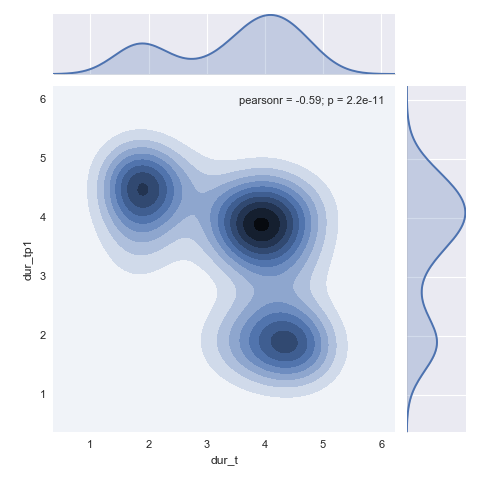

/Users/noranickels/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [6]:
import seaborn as sns
sns.set(color_codes=True)

dur_t_tp1 = pd.concat([dur_t, dur_tp1], axis=1)
# dur_t_tp1
# dur_t_tp1_trunc = dur_t_tp1[1:-1]
# dur_t_tp1_trunc
sns.jointplot(x="dur_t", y="dur_tp1", data=dur_t_tp1, kind="kde")

If we want to control the bandwidth and plot the surface as a KDE smoothed version of the joint distribution, we can use the following code.

<IPython.core.display.Javascript object>


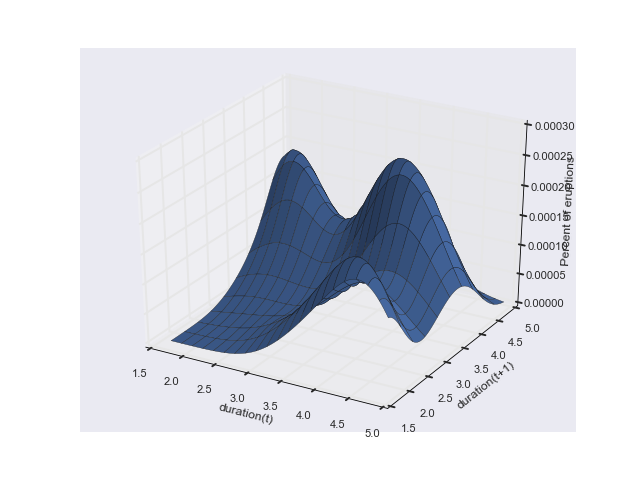

In [8]:
from scipy.stats import gaussian_kde

bandwidth = 0.5
kernel = gaussian_kde(dur_t_tp1.T, bw_method=bandwidth)

dur_t_min = dur_t.min()
dur_t_max = dur_t.max()
dur_tp1_min = dur_tp1.min()
dur_tp1_max = dur_tp1.max()

dur_t_i, dur_tp1_i = np.mgrid[dur_t_min:dur_t_max:100j,
                              dur_tp1_min:dur_tp1_max:100j]
coords = np.vstack([item.ravel() for item in [dur_t_i, dur_tp1_i]])

# kernel(coords)

Z = np.reshape(kernel(coords), dur_t_i.shape)
Z_scaled = Z / float(np.sum(Z))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(dur_t_i, dur_tp1_i, Z_scaled, rstride=5)
ax.set_xlabel("duration(t)")
ax.set_ylabel("duration(t+1)")
ax.set_zlabel("Percent of eruptions")

### 3.2. Two-dimensional data: bequests (inheritances)

The following data are from Italy. They represent the percent of bequests (inheritances) each year that are received by Italian individuals by age and by lifetime income group.

In [9]:
# Import the rough bequest distribution matrix and transpose it
BQ_mat_raw = np.loadtxt('data/BQ_mat_raw_ITA.txt', delimiter=',').T

# Some diagnostics
print('Shape of BQ_mat_raw', BQ_mat_raw.shape)
print('Bequest distribution by income group:',
      BQ_mat_raw.sum(axis=0))
print('Sum of all probabilities', BQ_mat_raw.sum())

Shape of BQ_mat_raw (51, 7)
Bequest distribution by income group: [ 0.          0.          0.00149992  0.03048317  0.1224768   0.68240364
  0.16313647]
Sum of all probabilities 0.99999999483


Because the sum of all probabilities is not exactly equal to 1.0, I rescale the matrix.

1.0


<IPython.core.display.Javascript object>


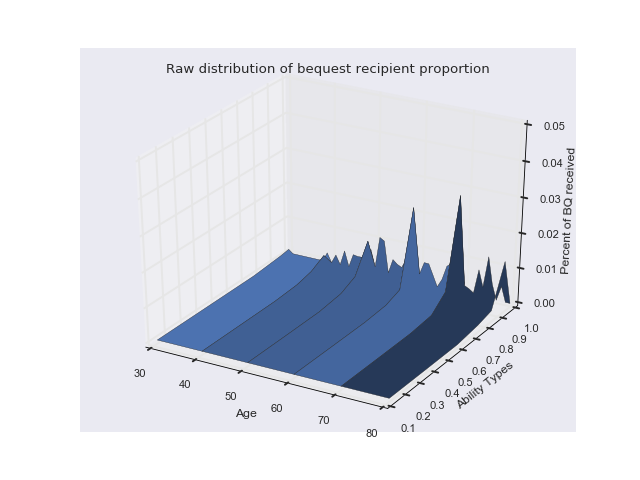

In [10]:
# Because the sum of all probabilities is not exactly equal
# to 1.0, I rescale the matrix.
BQ_mat_raw = BQ_mat_raw / BQ_mat_raw.sum()
print(BQ_mat_raw.sum())

# Make 3D surface plot of rough bequests distribution matrix
age_vec = np.arange(30, 81)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, BQ_mat_raw)
ax.set_title('Raw distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Ability Types')
ax.set_zlabel('Percent of BQ received')

I don't believe that the percent of bequests really jumps around from age to age like we see in this data. In your kernel density estimation exercise in Problem Set 2, you will fit a smoothed density to the U.S. version of these data.

## 4. References
* Hastie, Trevor, Robert Tibshirani, and Jerome Friedman, *The Elements of Statistical Learning: Data Mining, Inference, and Prediction*, 2nd edition, Springer (2009).
* Scott, David W., *Multivariate Density Estimation: Theory, Practice, and Visualization*, 2nd edition, Wiley (2015).
* VanderPlas, Jake, *Python Data Science Handbook: Essential Tools for Working with Data*, O'Reilly (2017).